In [1]:
# Import needed functionalities
import math
import numpy as np
import pandas as pd
import scipy.spatial.distance as ssd
from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from sklearn.cluster import KMeans
# from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing

In [2]:
# Import datasets
data3Dfull = pd.read_csv('data/data3.csv')
data6Dfull = pd.read_csv('data/data6.csv')

In [4]:
# method to sample a dataset (hardcoded seed for randomized selection, see alternatives in comment)
def get_sample_from_dataset(prop, dataset):
    # randomly define sample from dataset
    # good seeds to try: 13, 42, 1123, 5813, 213455
    np.random.seed(seed=42)
    # We are going to use bootstrapping
    sample_proportion =  prop
    dataset_size = len(dataset)
    sample_size = sample_proportion * dataset_size
    # perform scaling on the dataset
    dataset = preprocessing.scale(dataset)
    # Turn into a pandas array again
    d = {'V'+str(i+1) : dataset[:,i] for i in range(len(dataset[0]))}
    dataset = pd.DataFrame(d)
    
    print("The sample size we are going to use will be: "+ str(sample_size))
    # Run the sampling
    chosen_idx = np.random.choice(dataset_size, replace=False, size=int(sample_size))
    sampled_dataset =  dataset.iloc[chosen_idx]
    print("The new shape of the sampled dataset is: " + str(sampled_dataset.values.shape))
    return sampled_dataset

In [5]:
data3D = get_sample_from_dataset(0.05, data3Dfull)
data6D = get_sample_from_dataset(0.05, data6Dfull)

The sample size we are going to use will be: 15000.0
The new shape of the sampled dataset is: (15000, 3)
The sample size we are going to use will be: 15000.0
The new shape of the sampled dataset is: (15000, 6)


In [6]:
# Number of clusters
nClusters = 28

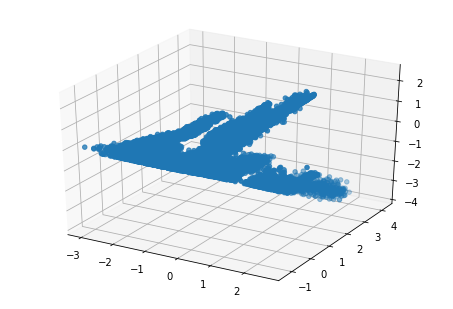

In [7]:
# Plot 3D figure
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data3D['V1'], data3D['V2'], data3D['V3'])

In [8]:
def run_gmm(nClusters, data, use_kmeans=True):
    method = 'kmeans' if use_kmeans else 'random'
    gmm = GaussianMixture(nClusters, init_params=method) #be default initialises using kmeans
    gmm = gmm.fit(data)
    labels = gmm.predict(data)
    means = gmm.means_
    return gmm, labels, means

In [10]:
# Experiment: likelihood evaluation
likelihood_experiment_enabled = True

n_samples = 10 #obtain likelihoods on this same sample
# see nClusters

likely = {'3d_kmeans' : 0, '6d_kmeans' : 0, '3d_random' : 0, '6d_random' : 0}
if likelihood_experiment_enabled:
    #gather sample likelihoods
    likely = {'3d_kmeans' : np.zeros((n_samples,)), '6d_kmeans' : np.zeros((n_samples,)), '3d_random' : np.zeros((n_samples,)), '6d_random' : np.zeros((n_samples,))}
    
    for exp_idx in range(n_samples):
        print("sample: " + str(exp_idx) + "\r")
        gmm_3d_kmeans, labels, C = run_gmm(nClusters, data3D, True)
        gmm_6d_kmeans, labels, C = run_gmm(nClusters, data6D, True)
        gmm_3d_random, labels, C = run_gmm(nClusters, data3D, False)
        gmm_6d_random, labels, C = run_gmm(nClusters, data6D, False)
        
        likely['3d_kmeans'][exp_idx] = math.exp(gmm_3d_kmeans.score(data3D))
        likely['6d_kmeans'][exp_idx] = math.exp(gmm_6d_kmeans.score(data6D))
        likely['3d_random'][exp_idx] = math.exp(gmm_3d_random.score(data3D))
        likely['6d_random'][exp_idx] = math.exp(gmm_6d_random.score(data6D))

# print e^log_likelihoods
print("gmm_3d_kmeans likelihood: ", str(np.mean(likely['3d_kmeans'])) + " std: " + str(np.std(likely['3d_kmeans'])))
print("gmm_6d_kmeans likelihood: ", str(np.mean(likely['6d_kmeans'])) + " std: " + str(np.std(likely['6d_kmeans'])))
print("gmm_3d_random likelihood: ", str(np.mean(likely['3d_random'])) + " std: " + str(np.std(likely['3d_random'])))
print("gmm_6d_random likelihood: ", str(np.mean(likely['6d_random'])) + " std: " + str(np.std(likely['6d_random'])))

sample: 0
sample: 1
sample: 2
sample: 3
sample: 4
sample: 5
sample: 6
sample: 7
sample: 8
sample: 9
gmm_3d_kmeans likelihood:  0.288450852682 std: 0.00272508851354
gmm_6d_kmeans likelihood:  0.00063175024647 std: 1.38975398522e-05
gmm_3d_random likelihood:  0.282395202996 std: 0.00825258910571
gmm_6d_random likelihood:  0.000604573700762 std: 1.67449157973e-05


In [54]:
# fig = plt.figure()
# ax = Axes3D(fig)
#Instead of using colours for each predefined cluster, we use a colour for each predicted label
# ax.scatter(data3D['V1'], data3D['V2'], data3D['V3'], c=labels, zorder=-50000)
# ax.scatter(C[:,0], C[:,1], C[:,2], marker='*', c='#050505', s=1000, zorder=50000)
# ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c='#050505', s=1000)
# gmm_3d_kmeans, labels, C = run_gmm(25, data3D, True)
# labels.shape


In [12]:
# IDS challenge
# This experiment takes a moment to perform
nSamples = 15 #how often to try a new clustering

cluster_assignments = np.zeros((len(data3Dfull),nClusters))

for exp_idx in tqdm(range(nSamples)):
#     exp_data = get_sample_from_dataset(1, data3Dfull)
    exp_data = preprocessing.scale(data3Dfull)
    exp_gmm, labels, C = run_gmm(nClusters, exp_data, True)
    
    for idx, label in enumerate(labels):
        cluster_assignments[idx, label] += 1
        
# Assign to cluster most often predicted
in_cluster = np.argmax(cluster_assignments, axis=1)

100%|██████████| 15/15 [10:11<00:00, 40.80s/it]


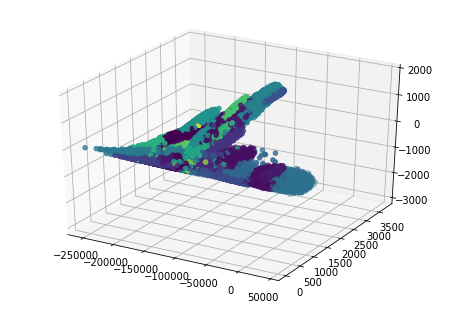

In [13]:
# Show cluster assignment
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data3Dfull['V1'], data3Dfull['V2'], data3Dfull['V3'], c=in_cluster, zorder=-50000)

In [14]:
# Save cluster assignment
np.savetxt("Team_14_clustering.csv", in_cluster.astype(int), fmt='%i', delimiter=',')

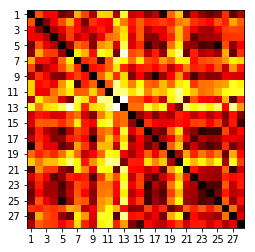

In [16]:
# Compute cluster means in order to see inter cluster distances
cluster_means = np.zeros((nClusters, len(exp_data[0])))

clusterSize = np.zeros((nClusters,))
exp_data.shape
# Gather all clusters
for idx in range(len(exp_data)):
    cluster_means[in_cluster[idx]] += exp_data[idx]
    clusterSize[in_cluster[idx]] += 1

# Normalise cluster means by number of stars
for c in range(nClusters):
    cluster_means[c] /= clusterSize[c]

# print(cluster_means)

# Distance matrix visualisation
distances = np.zeros((nClusters,nClusters))
for y in range(nClusters):
    for x in range(nClusters):
        distances[y][x] = ssd.euclidean(cluster_means[y], cluster_means[x])
        
plt.imshow(distances,cmap='hot')
ax = plt.gca()
clustRange = np.arange(0, nClusters, 2)
ax.grid(False)
ax.set_xticks(clustRange);
ax.set_yticks(clustRange);
ax.set_xticklabels(clustRange + 1);
ax.set_yticklabels(clustRange + 1);


In [35]:
def dist(a,b, metric='euclidean'):
    dist = ssd.euclidean(a, b) if metric=='euclidean' else ssd.cityblock(a, b)
    return dist

# Get sse for clusters
# sse = np.zeros((nClusters,))
# for idx in tqdm(range(len(exp_data))):
#     sse[in_cluster[idx]] += dist(exp_data[idx], cluster_means[in_cluster[idx]])**2

np.set_printoptions(precision=4, suppress=True)
print(np.expand_dims(sse,0).transpose())

[[  16842.0534]
 [  56790.9414]
 [ 144286.4359]
 [   2116.9421]
 [  15606.1652]
 [  26285.5832]
 [   4625.1775]
 [  90874.9017]
 [    205.3687]
 [   3474.8766]
 [  74719.7095]
 [   4077.6521]
 [   4815.3569]
 [   1760.2501]
 [   1477.3588]
 [   6643.1343]
 [   1368.854 ]
 [  18006.4982]
 [    986.7723]
 [    720.726 ]
 [    214.3615]
 [      2.2775]
 [    406.0473]
 [      2.3244]
 [    102.5682]
 [      0.8805]
 [     27.8287]
 [      3.4797]]
